# Bank Note Authentication using K-Means Clustering

In [40]:
import pandas as pd

#### Reading the bank note data file downloaded from opneml

In [41]:
data = pd.read_csv("bank_note_dataset.csv")
display(data)

,V1,V2,V3,V4,Class
0,3.62160,8.66610,-2.8073,-0.44699,1
1,4.54590,8.16740,-2.4586,-1.46210,1
2,3.86600,-2.63830,1.9242,0.10645,1
3,3.45660,9.52280,-4.0112,-3.59440,1
4,0.32924,-4.45520,4.5718,-0.98880,1
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,2
1368,-1.38870,-4.87730,6.4774,0.34179,2
1369,-3.75030,-13.45860,17.5932,-2.77710,2
1370,-3.56370,-8.38270,12.3930,-1.28230,2


#### Describing 4 features from the dataset extracted from the bank note images using a Wavelet Transform tool.
##### V1. variance of Wavelet Transformed image (continuous)
##### V2. skewness of Wavelet Transformed image (continuous)
##### V3. curtosis of Wavelet Transformed image (continuous)
##### V4. entropy of image (continuous)

In [42]:
data[["V1","V2","V3","V4"]].describe()

,V1,V2,V3,V4
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


#### Printing correlation matrix to find significant features.
##### From the below result we can clearly see the V1 and V2 columns has higher correlation, thus have higher significance on determining the Class of banknote

In [43]:
data.corr()

,V1,V2,V3,V4,Class
V1,1.000000,0.264026,-0.380850,0.276817,-0.724843
V2,0.264026,1.000000,-0.786895,-0.526321,-0.444688
V3,-0.380850,-0.786895,1.000000,0.318841,0.155883
V4,0.276817,-0.526321,0.318841,1.000000,-0.023424
Class,-0.724843,-0.444688,0.155883,-0.023424,1.000000


#### Selecting V1 and V2 columns for further analysis

In [44]:
significant_feature_data = data[["V1","V2"]]

#### Plotting V2 against V1

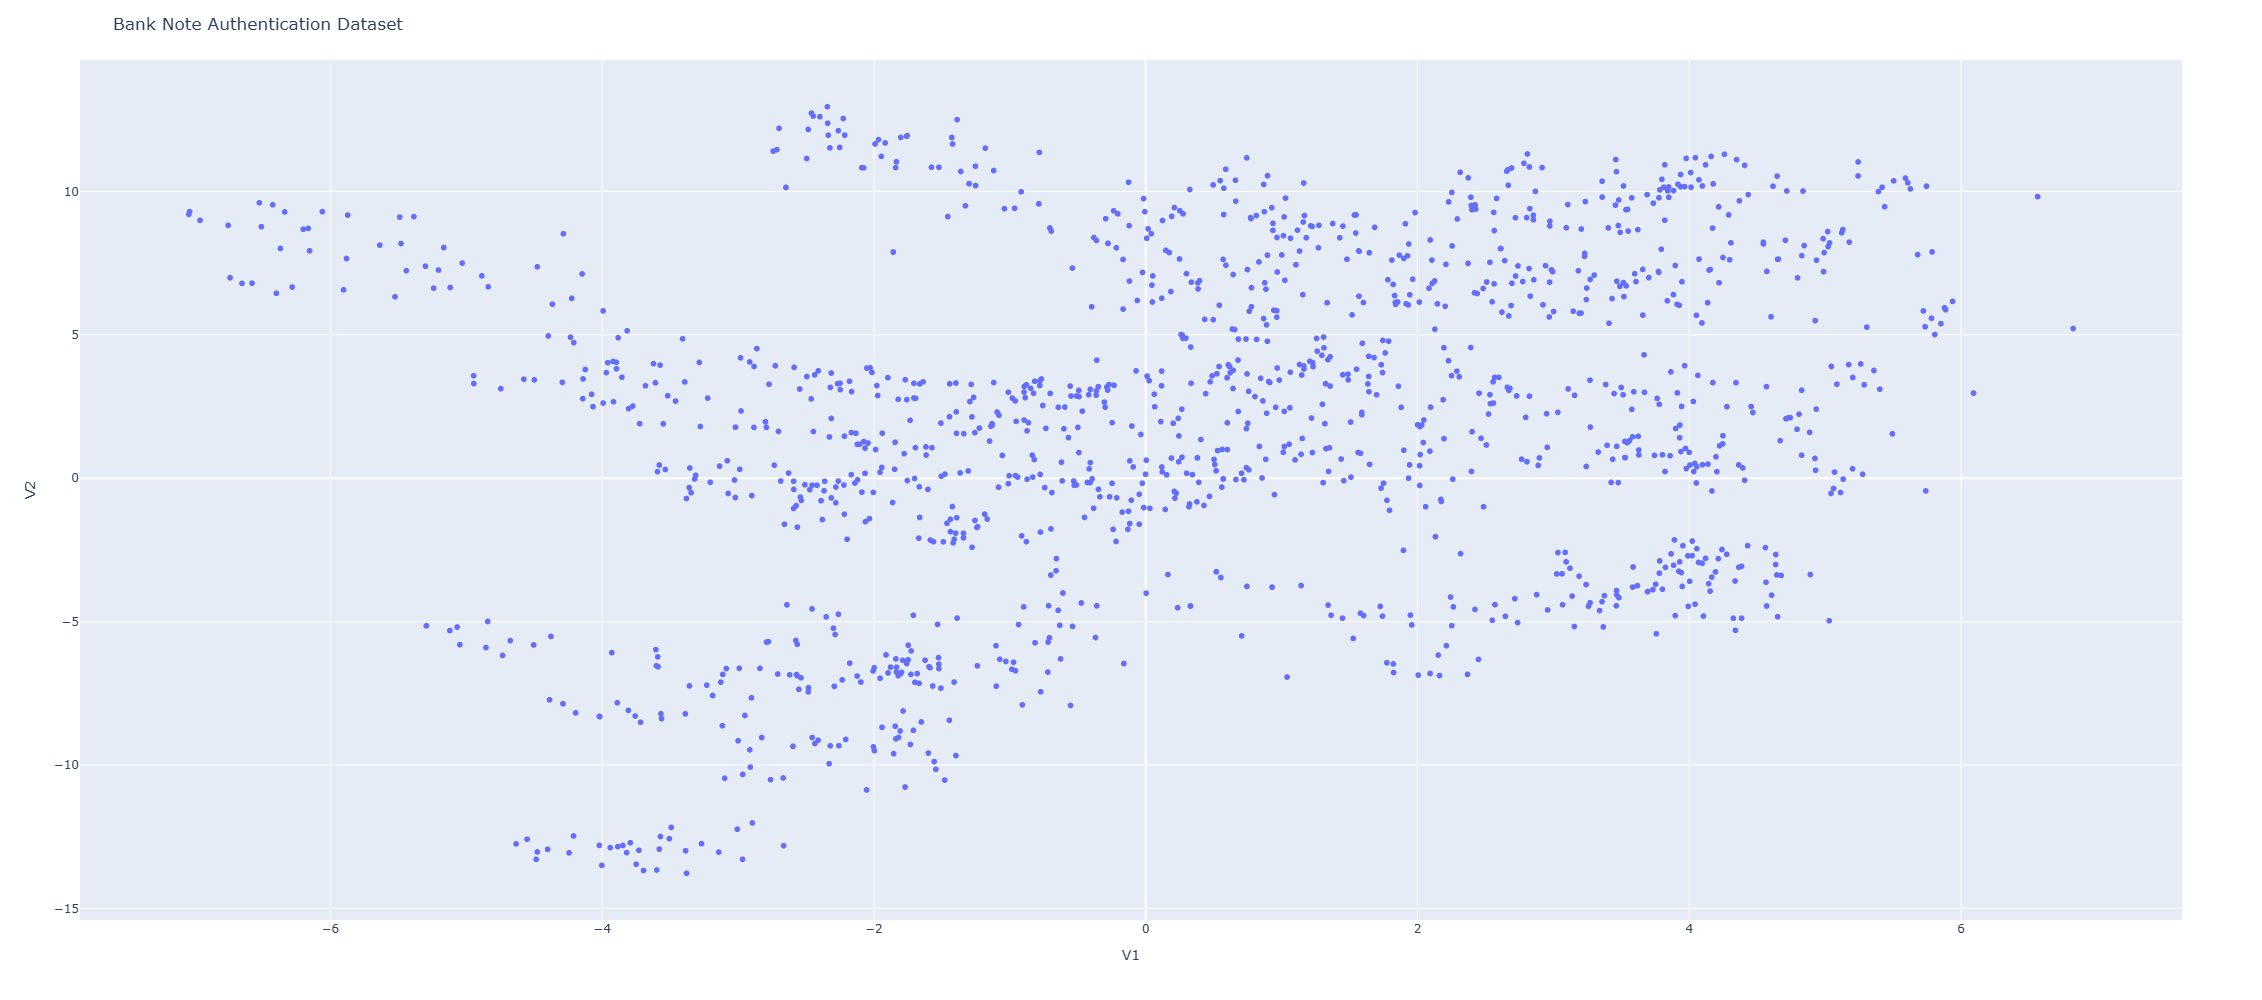

In [45]:
import plotly.express as px
fig = px.scatter(significant_feature_data,x="V1",y="V2",width=1000,height=1000)
fig.update_layout(title="Bank Note Authentication Dataset")
fig.show()

#### Normalizing the data to remove measurement scale bias

In [46]:
normalized_data = (significant_feature_data - significant_feature_data.mean())/significant_feature_data.std()
display(normalized_data)

,V1,V2
0,1.121397,1.149036
1,1.446538,1.064065
2,1.207369,-0.777069
3,1.063355,1.295005
4,-0.036758,-1.086642
...,...,...
1367,-0.009707,-0.097657
1368,-0.641079,-1.158562
1369,-1.471820,-2.620690
1370,-1.406180,-1.755831


#### Post Normalization the data have 0 Mean and 1 Standard Deviation

In [47]:
normalized_data.mean()

V1    0.000000e+00
V2    4.143106e-17
dtype: float64

In [48]:
normalized_data.std()

V1    1.0
V2    1.0
dtype: float64

In [49]:
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### Performing K-Means Clustering to identify the 2 clusters of Genuine and Forged Bank Note

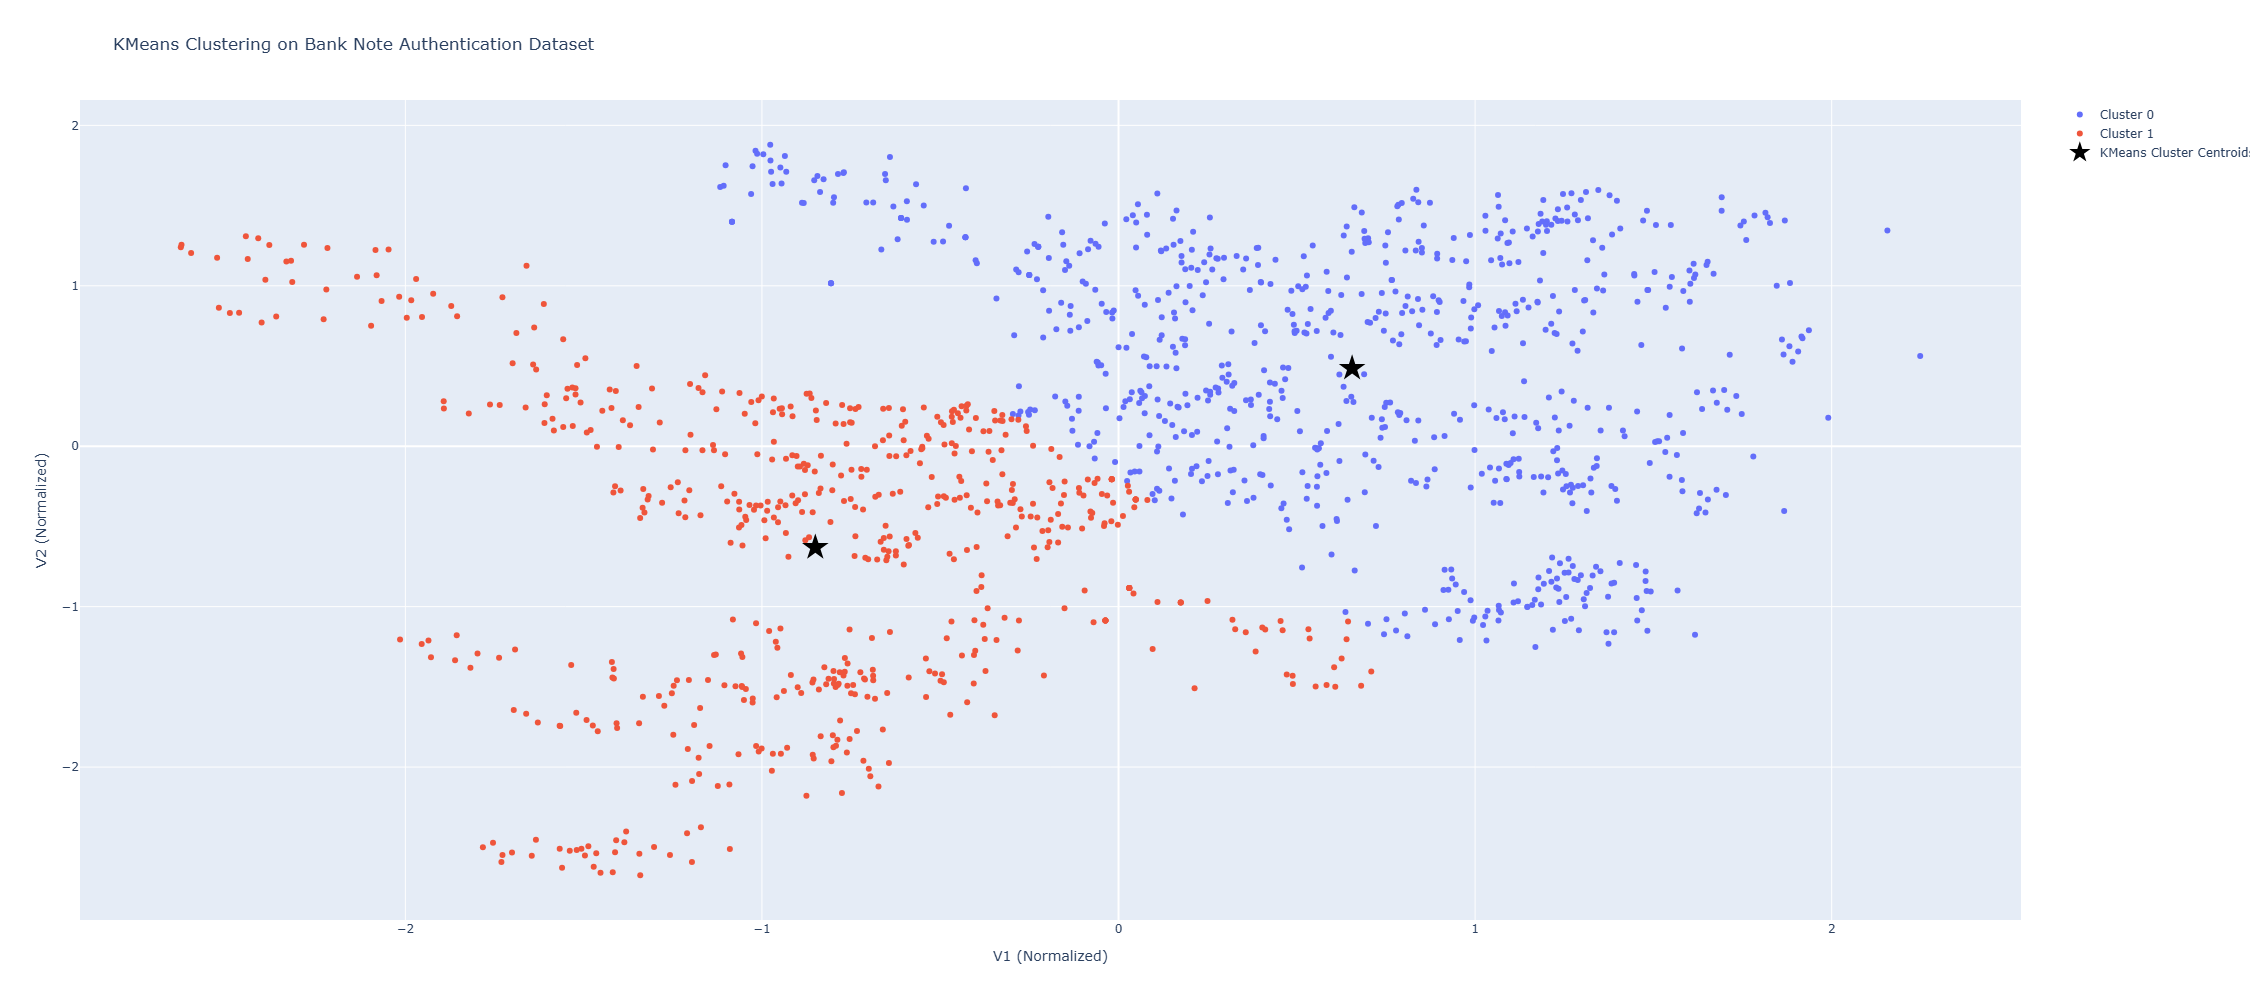

In [56]:
kmeans_result_final = KMeans(n_clusters=2).fit(normalized_data)
kmeans_data_final = normalized_data.copy()
kmeans_data_final["lable"] = kmeans_result_final.labels_

fig = go.Figure()
fig.update_layout(width=1200,height=1000,xaxis_title="V1 (Normalized)",yaxis_title="V2 (Normalized)",title="KMeans Clustering on Bank Note Authentication Dataset")
for label in kmeans_data_final["lable"].unique():
    current_label_data = kmeans_data_final[kmeans_data_final["lable"] == label]
    fig.add_trace(go.Scatter(x=current_label_data["V1"],y=current_label_data["V2"],mode="markers",name=f"Cluster {label}"))
fig.add_trace(go.Scatter(x=kmeans_result_final.cluster_centers_[:,0],y=kmeans_result_final.cluster_centers_[:,1],mode="markers",marker_symbol="star",marker_size=20,marker_color="black",name="KMeans Cluster Centroids"))
fig.show()

#### Ran the K-Means Model for 10 more times to check the stability of the model
##### The results are very similar to each other. The cluster centers remained almost unchanged for multiple iterations. Thus we can safely say that the model is stable.

Interation 1 Cluster Centers - [[ 0.65698737  0.48740132]
 [-0.84783179 -0.62898368]]
Interation 2 Cluster Centers - [[ 0.65956516  0.49403094]
 [-0.83865238 -0.62817179]]
Interation 3 Cluster Centers - [[ 0.65698737  0.48740132]
 [-0.84783179 -0.62898368]]
Interation 4 Cluster Centers - [[ 0.65698737  0.48740132]
 [-0.84783179 -0.62898368]]
Interation 5 Cluster Centers - [[-0.8650285  -0.63749275]
 [ 0.64684297  0.4766984 ]]
Interation 6 Cluster Centers - [[-0.83865238 -0.62817179]
 [ 0.65956516  0.49403094]]
Interation 7 Cluster Centers - [[ 0.64684297  0.4766984 ]
 [-0.8650285  -0.63749275]]
Interation 8 Cluster Centers - [[ 0.64563808  0.47630588]
 [-0.86599238 -0.63886762]]
Interation 9 Cluster Centers - [[ 0.65698737  0.48740132]
 [-0.84783179 -0.62898368]]
Interation 10 Cluster Centers - [[ 0.65956516  0.49403094]
 [-0.83865238 -0.62817179]]


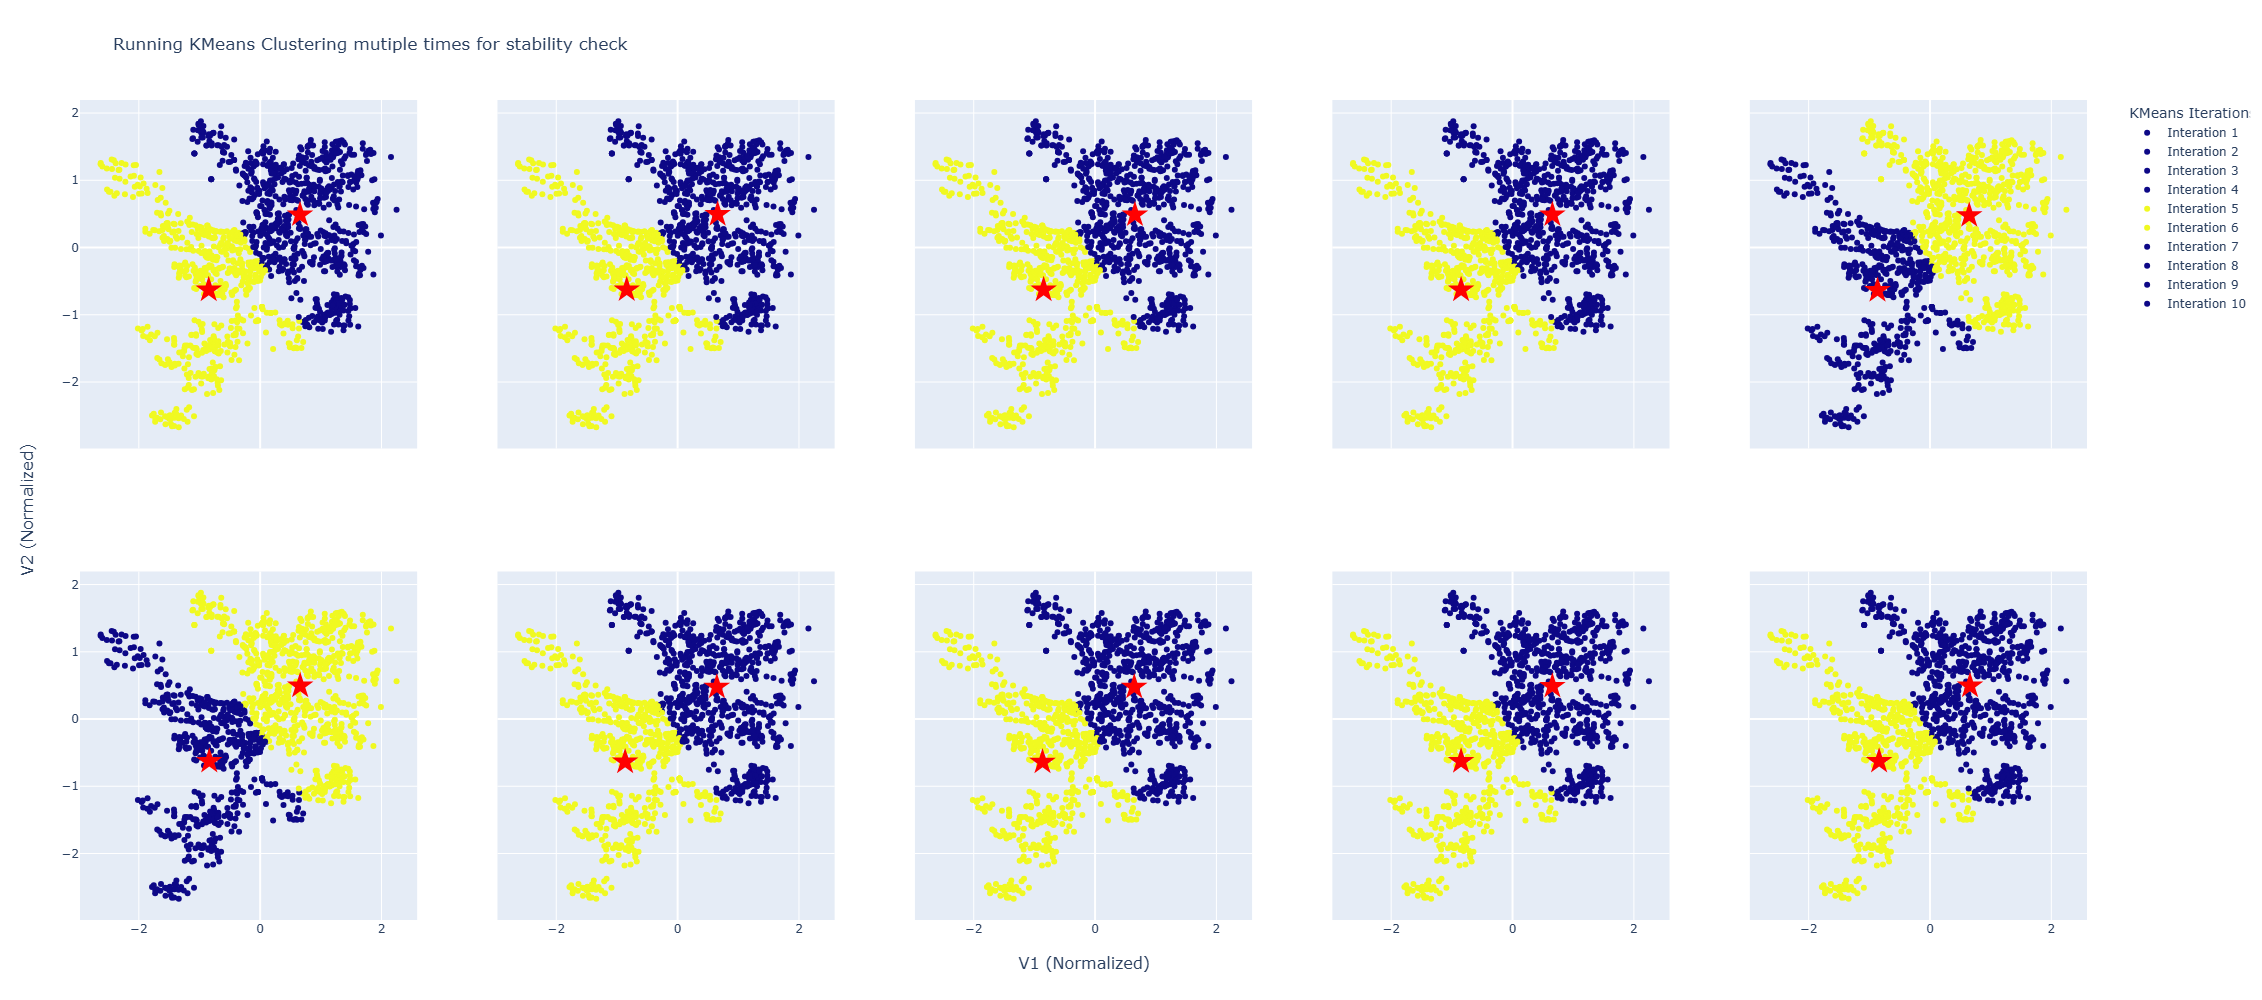

In [68]:
fig = make_subplots(2,5,shared_xaxes=True,shared_yaxes=True,x_title="V1 (Normalized)",y_title="V2 (Normalized)")
for i in range(2):
    for j in range(5):
        kmeans_result = KMeans(n_clusters=2).fit(normalized_data)
        print(f"Interation {i*5+j+1} Cluster Centers - {kmeans_result.cluster_centers_}")
        fig.add_trace(go.Scatter(x=normalized_data["V1"],y=normalized_data["V2"],mode="markers",marker_color=kmeans_result.labels_,name=f"Interation {i*5+j+1}"),row=i+1,col=j+1)
        fig.add_trace(go.Scatter(x=kmeans_result.cluster_centers_[:,0],y=kmeans_result.cluster_centers_[:,1],mode="markers",marker_symbol="star",marker_size=20,marker_color="red",showlegend=False),row=i+1,col=j+1)
fig.update_layout(height=1000,legend_title_text="KMeans Iterations",title="Running KMeans Clustering mutiple times for stability check")
fig.show()

In [69]:
from sklearn.metrics import accuracy_score

#### Finding the accuracy of the model
##### Seeing the result we can confidently conclude that the model can authenticate bank notes with ≈ 88% accuracy

In [70]:
openml_map_dict = {0:1,1:2}
print(accuracy_score(list(map(lambda x: openml_map_dict[x],kmeans_result_final.labels_)),data["Class"]))

0.8782798833819242


In [71]:
data_with_accuracy = significant_feature_data.copy()
data_with_accuracy["accurate"] = [True if openml_map_dict[kmeans_data_final.at[i,"lable"]] == data.at[i,"Class"] else False for i in range(kmeans_data_final.shape[0])]
display(data_with_accuracy)

,V1,V2,accurate
0,3.62160,8.66610,True
1,4.54590,8.16740,True
2,3.86600,-2.63830,True
3,3.45660,9.52280,True
4,0.32924,-4.45520,False
...,...,...,...
1367,0.40614,1.34920,False
1368,-1.38870,-4.87730,True
1369,-3.75030,-13.45860,True
1370,-3.56370,-8.38270,True


#### Plotting the data set with accuracy lables for data point on whether the K-Means model was able to correctly cluster that data point or not
##### The plot gives us a pretty good idea of the confidence level of the model. We can clearly see that except a few point on the borderline, most data points are correctly clustered

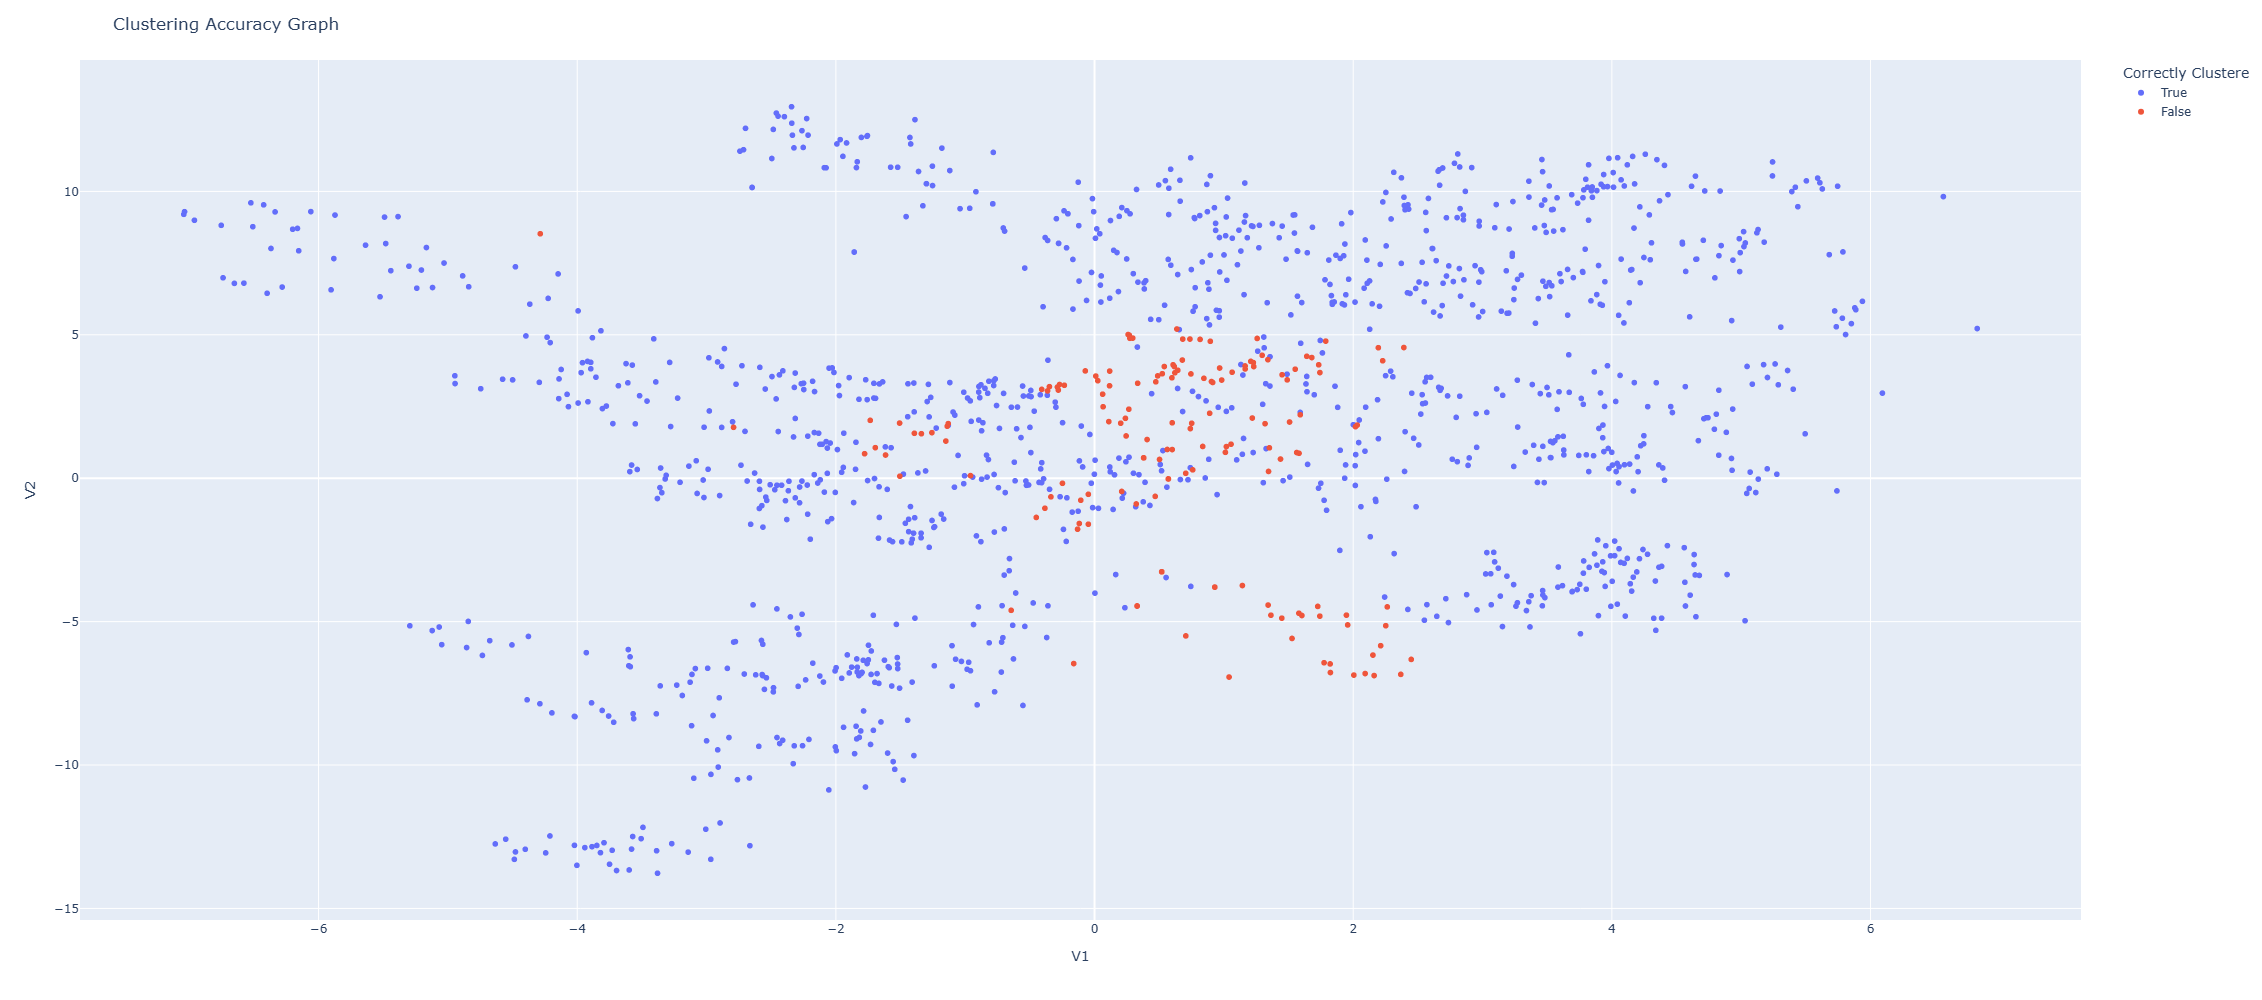

In [72]:
fig = px.scatter(data_with_accuracy,x="V1",y="V2",color="accurate",width=1000,height=1000)
fig.update_layout(legend_title_text="Correctly Clustered",title="Clustering Accuracy Graph")
fig.show()

#### Final Recommendation-
The outcome of the project is very positive. I achieved an accuracy score of ≈ 88% which will help in identifying the forged notes more easily. Also, the model is very stable and thus an ideal candidate for a finance-related sensitive environment. The K-means model was able to clearly identify all forged ntsse having less variance. It struggled only a bit for forged bank notes having moderate variance. Thus my recommendation will be to use this model as a first level filter for identifying forged bank notes. Though manual checking will still be required for some bank notes with moderate variance. But still, it can automate almost 90% of the process.